# Imports

In [19]:
import os
import glob
import json
import ast
import re

from typing import Dict

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Utils

In [20]:
def get_metabolite_info():
    metabolite_data = pd.read_csv('./data/metabolites.txt', delimiter='\t')
    raw_metabolites = pd.read_csv('./data/metabolites_dataset.data_prep.tsv', delimiter='\t')

    return raw_metabolites.merge(
        metabolite_data, 
        left_on='official_name', right_on='met_name'
    )[['metabolite_id', 'official_name', 'kegg_id', 'pathway', 'method', 'Order']].drop_duplicates().set_index('metabolite_id')

In [21]:
metabolite_info = get_metabolite_info()

In [22]:
metabolite_info

,official_name,kegg_id,pathway,method,Order
metabolite_id,,,,,
adp,ADP,C00008,Energy metabolism,PPP,2
amp,AMP,C00020,Energy metabolism,PPP,3
atp,ATP,C00002,Energy metabolism,PPP,1
accoa,Acetyl-CoA,C00024,TCA,TCA,1
dhap,Dihydroxyacetone phosphate,C00111,Glycolysis,TCA,5
f6p,D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2
fum,Fumarate,C00122,TCA,TCA,6
g3p,Glyceraldehyde 3-phosphate,C00661,Glycolysis,TCA,4
mal-L,L-Malate,C00149,TCA,TCA,7


# Experiments

## Experiments simple baseline

In [23]:
dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_simple_baseline"
paths = glob.glob(dir + "/*.csv")

In [24]:
# {
#     'regressor__regressor': [GammaRegressor()],
#     'regressor__regressor__alpha': [0, 1, 10],
#     'transformer': [MinMaxScaler()],
# }, {
#     'regressor__regressor': [DecisionTreeRegressor()],
#     'regressor__regressor__criterion': ['squared_error', 'friedman_mse'],
#     'regressor__regressor__max_depth': [None, 5, 10, 20, 15]
# }, {
#     'regressor__regressor': [SVR()],
#     'regressor__regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
# }, {
#     'regressor__regressor': [ElasticNet()],
#     'regressor__regressor__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
# }

In [25]:
def rename(name: str):
    name = name.removeprefix('param_regressor__')
    name = name.removesuffix('_test_score')
    return name

def fmt(param: str):
    param = param.replace('{', '').replace('}', '').replace('regressor__regressor__', '').replace("\'", '')
    param = param.split(',')[1:]
    param = [param.strip() for param in param if "=" not in param]
    return '\n'.join(param)

metabolites_names = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('Strategy.METABOLITE_CENTRIC_') for path in paths]
df = pd.concat([
    pd.read_csv(path).assign(metabolite_id=metabolite_name) 
    for path, metabolite_name in zip(paths, metabolites_names)
])
df.columns = df.columns.map(lambda name: rename(name))
df['regressor'] = df['regressor'].replace(to_replace=r'^DecisionTreeRegressor.*', value="DecisionTreeRegressor()", regex=True)
df['mean'] = -1 * df['mean']
df['std'] = -1 * df['std']
df['regressor'].replace(to_replace=r'^DecisionTreeRegressor.*', value="DecisionTreeRegressor()", regex=True).unique()
df['params_fmt'] = df['params'].map(lambda param: fmt(param))
df = df.merge(metabolite_info, left_on='metabolite_id', right_index=True)
df

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,regressor,regressor__alpha,param_transformer,regressor__criterion,regressor__max_depth,...,mean,std,rank,metabolite_id,params_fmt,official_name,kegg_id,pathway,method,Order
0,0,0.011982,0.002254,0.000000,0.000000,GammaRegressor(),0.0,MinMaxScaler(),NaN,NaN,...,NaN,NaN,22,oaa,alpha: 0\ntransformer: MinMaxScaler(),Oxaloacetate,C00036,TCA,TCA,8
1,1,0.014943,0.003624,0.000000,0.000000,GammaRegressor(),1.0,MinMaxScaler(),NaN,NaN,...,NaN,NaN,21,oaa,alpha: 1\ntransformer: MinMaxScaler(),Oxaloacetate,C00036,TCA,TCA,8
2,2,0.016312,0.002515,0.000000,0.000000,GammaRegressor(),10.0,MinMaxScaler(),NaN,NaN,...,NaN,NaN,20,oaa,alpha: 10\ntransformer: MinMaxScaler(),Oxaloacetate,C00036,TCA,TCA,8
3,3,0.036892,0.009424,0.008507,0.003811,DecisionTreeRegressor(),NaN,NaN,squared_error,NaN,...,1.198627e-15,-3.167112e-16,4,oaa,criterion: squared_error\nmax_depth: None,Oxaloacetate,C00036,TCA,TCA,8
4,4,0.025894,0.008019,0.008388,0.004431,DecisionTreeRegressor(),NaN,NaN,squared_error,5.0,...,6.599338e-02,-1.549914e-03,13,oaa,criterion: squared_error\nmax_depth: 5,Oxaloacetate,C00036,TCA,TCA,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,17,8.631664,0.778944,0.004668,0.001026,ElasticNet(),NaN,NaN,NaN,NaN,...,3.579135e-01,-6.923356e-03,14,accoa,l1_ratio: 0,Acetyl-CoA,C00024,TCA,TCA,1
18,18,0.028887,0.006906,0.008263,0.002747,ElasticNet(),NaN,NaN,NaN,NaN,...,3.811511e-01,-7.266398e-03,15,accoa,l1_ratio: 0.25,Acetyl-CoA,C00024,TCA,TCA,1
19,19,0.029481,0.005639,0.008188,0.002243,ElasticNet(),NaN,NaN,NaN,NaN,...,3.811511e-01,-7.266398e-03,15,accoa,l1_ratio: 0.5,Acetyl-CoA,C00024,TCA,TCA,1
20,20,0.029464,0.004176,0.008000,0.001555,ElasticNet(),NaN,NaN,NaN,NaN,...,3.811511e-01,-7.266398e-03,15,accoa,l1_ratio: 0.75,Acetyl-CoA,C00024,TCA,TCA,1


In [26]:
df['metabolite_id'].unique()

array(['oaa', 'asn-L', 'r5p', 'citr-L', 'hom-L', 'lys-L', 'glu-L',
       'his-L', 'dhap', 'orn', 'leu-L', 'arg-L', 'akg', 'gln-L', '6pgc',
       'ser-L', 'phe-L', 'mal-L', 'tyr-L', 'fum', 'amp', 'pyr', 'succ',
       'g3p', 'ru5p-D', 'adp', 'hcys-L', 'met-L', 'gly', 'cit', 'atp',
       'thr-L', 'val-L', 's7p', 'asp-L', 'f6p', 'fdp', 'pep', 'trp-L',
       'pro-L', 'accoa'], dtype=object)

In [27]:
# these metabolites need some further investigation as we do not know to which pathway they belong
df[~df['metabolite_id'].isin(metabolite_info.index)][['metabolite_id']].drop_duplicates()

,metabolite_id


In [28]:
df

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,regressor,regressor__alpha,param_transformer,regressor__criterion,regressor__max_depth,...,mean,std,rank,metabolite_id,params_fmt,official_name,kegg_id,pathway,method,Order
0,0,0.011982,0.002254,0.000000,0.000000,GammaRegressor(),0.0,MinMaxScaler(),NaN,NaN,...,NaN,NaN,22,oaa,alpha: 0\ntransformer: MinMaxScaler(),Oxaloacetate,C00036,TCA,TCA,8
1,1,0.014943,0.003624,0.000000,0.000000,GammaRegressor(),1.0,MinMaxScaler(),NaN,NaN,...,NaN,NaN,21,oaa,alpha: 1\ntransformer: MinMaxScaler(),Oxaloacetate,C00036,TCA,TCA,8
2,2,0.016312,0.002515,0.000000,0.000000,GammaRegressor(),10.0,MinMaxScaler(),NaN,NaN,...,NaN,NaN,20,oaa,alpha: 10\ntransformer: MinMaxScaler(),Oxaloacetate,C00036,TCA,TCA,8
3,3,0.036892,0.009424,0.008507,0.003811,DecisionTreeRegressor(),NaN,NaN,squared_error,NaN,...,1.198627e-15,-3.167112e-16,4,oaa,criterion: squared_error\nmax_depth: None,Oxaloacetate,C00036,TCA,TCA,8
4,4,0.025894,0.008019,0.008388,0.004431,DecisionTreeRegressor(),NaN,NaN,squared_error,5.0,...,6.599338e-02,-1.549914e-03,13,oaa,criterion: squared_error\nmax_depth: 5,Oxaloacetate,C00036,TCA,TCA,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,17,8.631664,0.778944,0.004668,0.001026,ElasticNet(),NaN,NaN,NaN,NaN,...,3.579135e-01,-6.923356e-03,14,accoa,l1_ratio: 0,Acetyl-CoA,C00024,TCA,TCA,1
18,18,0.028887,0.006906,0.008263,0.002747,ElasticNet(),NaN,NaN,NaN,NaN,...,3.811511e-01,-7.266398e-03,15,accoa,l1_ratio: 0.25,Acetyl-CoA,C00024,TCA,TCA,1
19,19,0.029481,0.005639,0.008188,0.002243,ElasticNet(),NaN,NaN,NaN,NaN,...,3.811511e-01,-7.266398e-03,15,accoa,l1_ratio: 0.5,Acetyl-CoA,C00024,TCA,TCA,1
20,20,0.029464,0.004176,0.008000,0.001555,ElasticNet(),NaN,NaN,NaN,NaN,...,3.811511e-01,-7.266398e-03,15,accoa,l1_ratio: 0.75,Acetyl-CoA,C00024,TCA,TCA,1


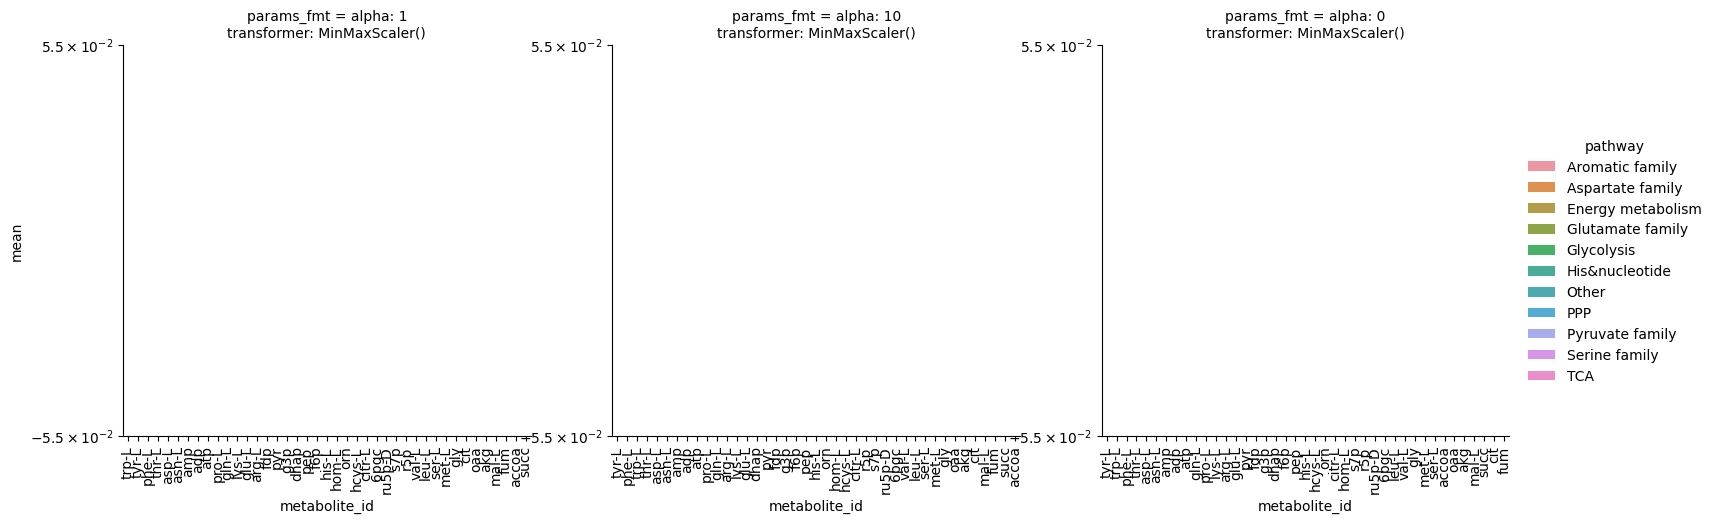

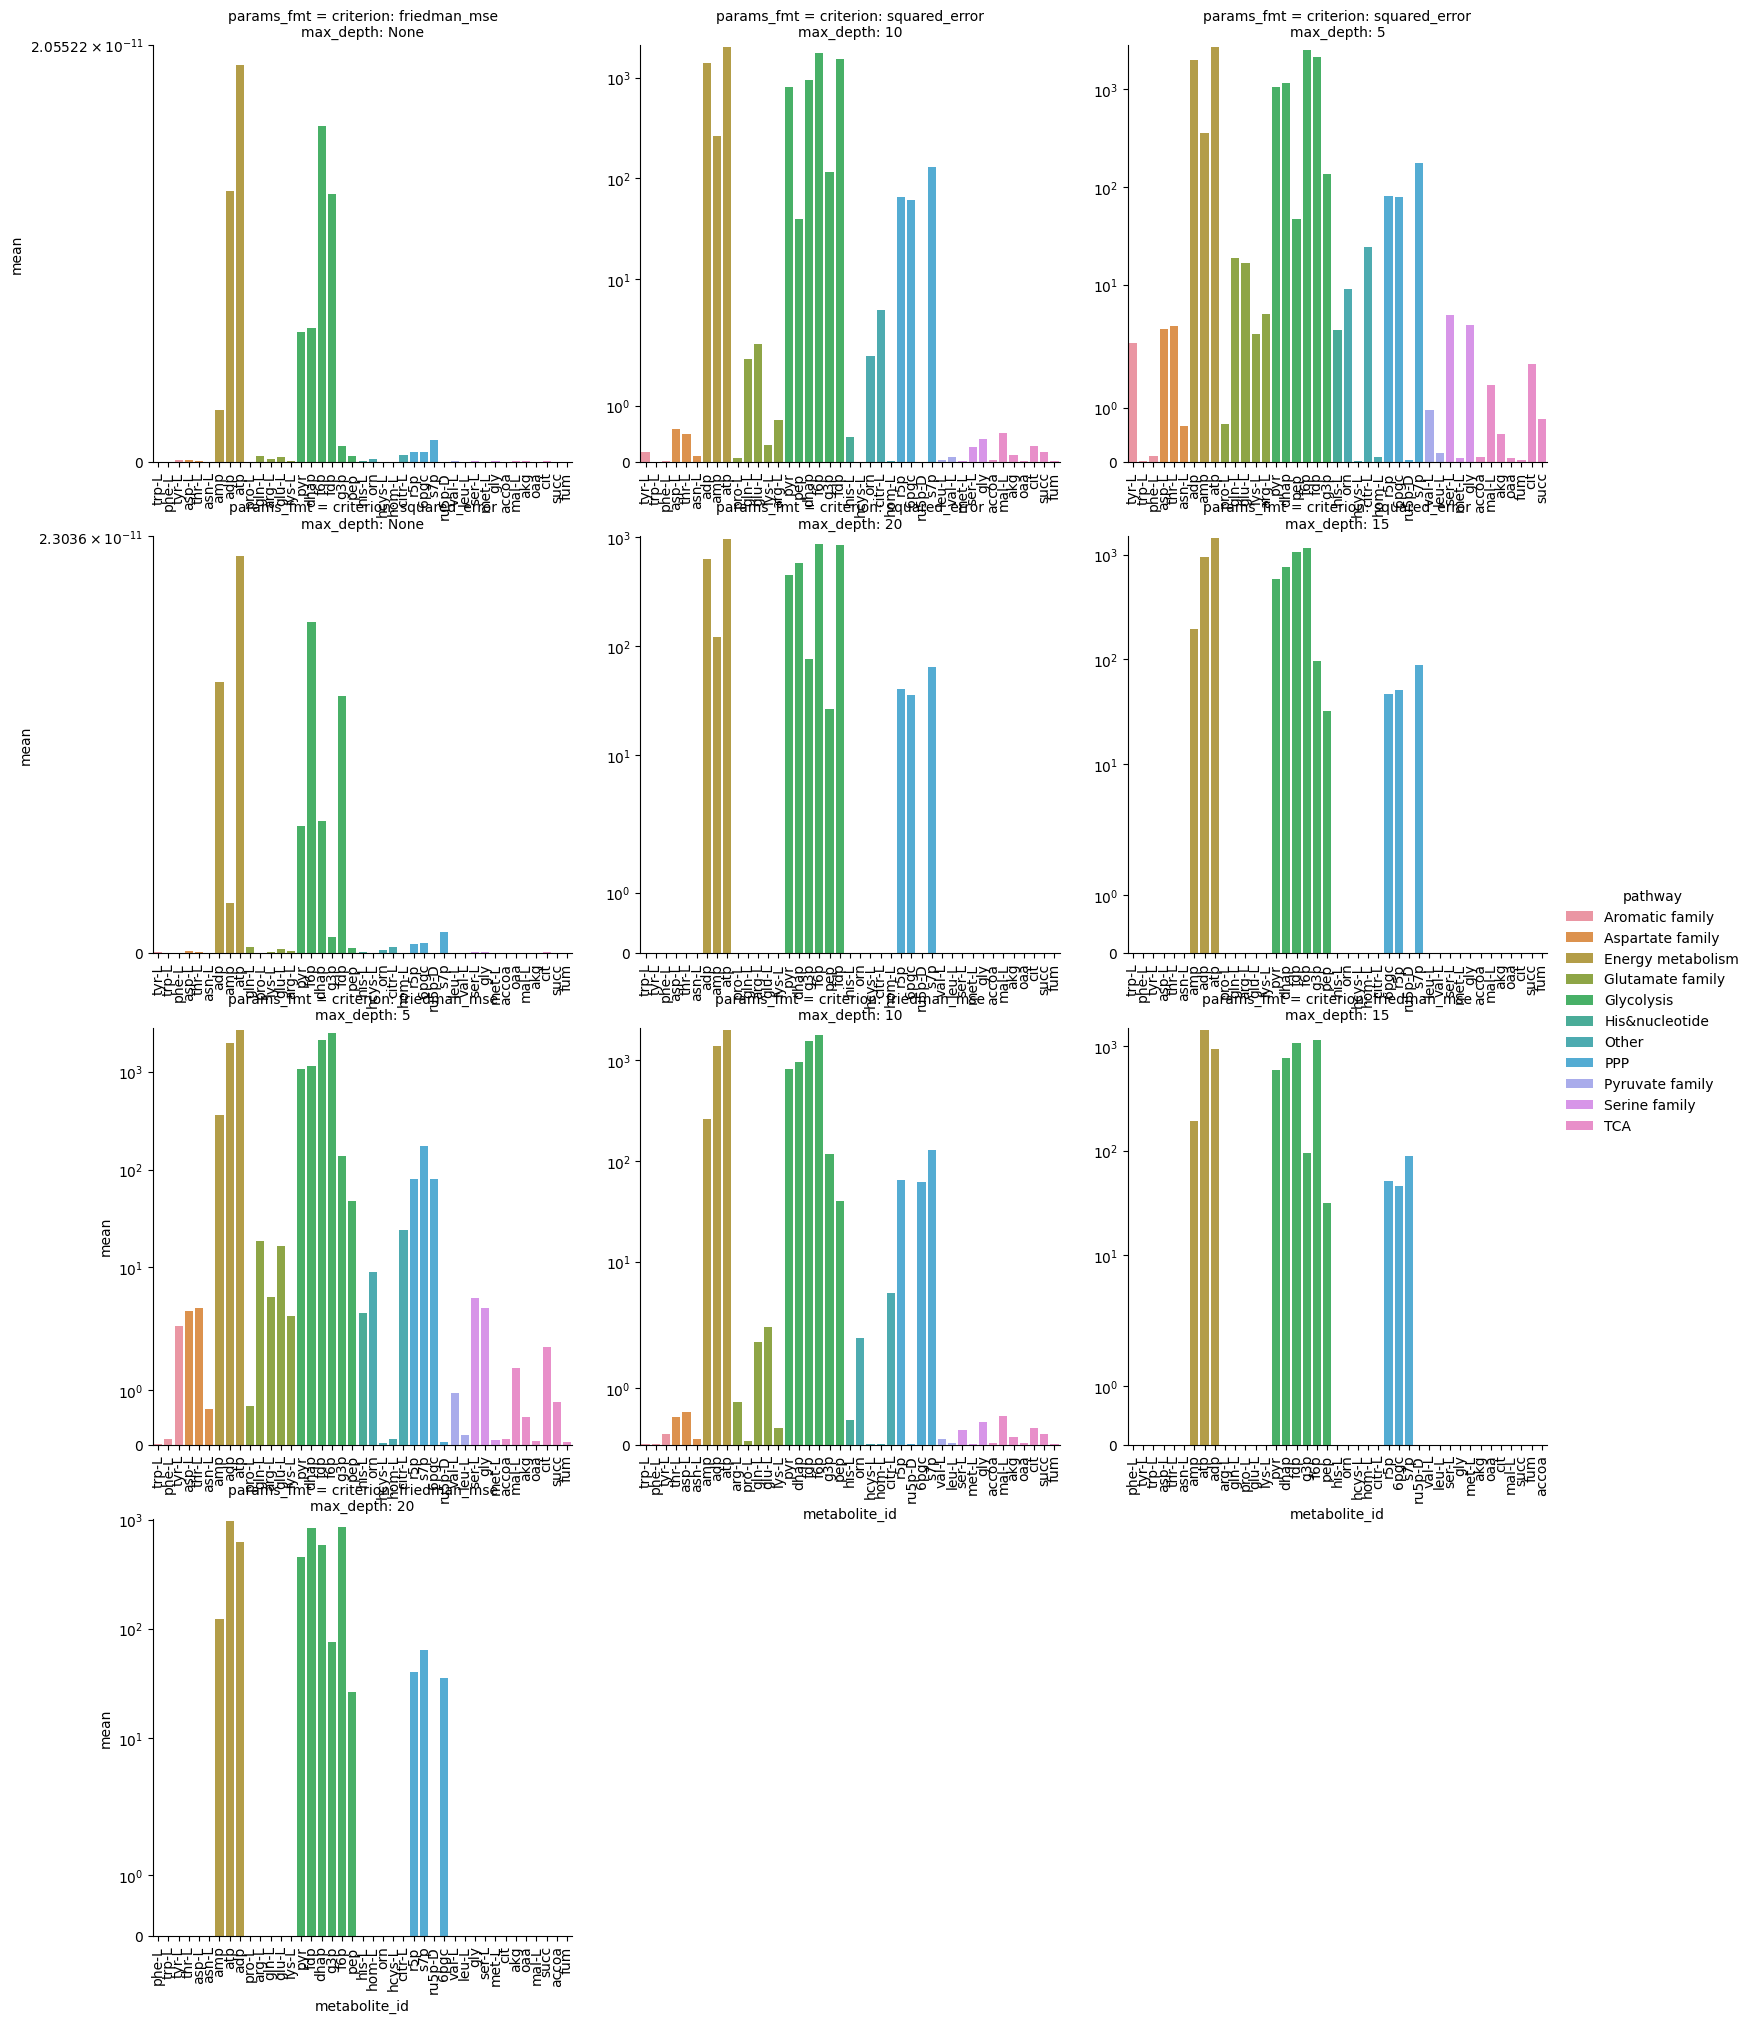

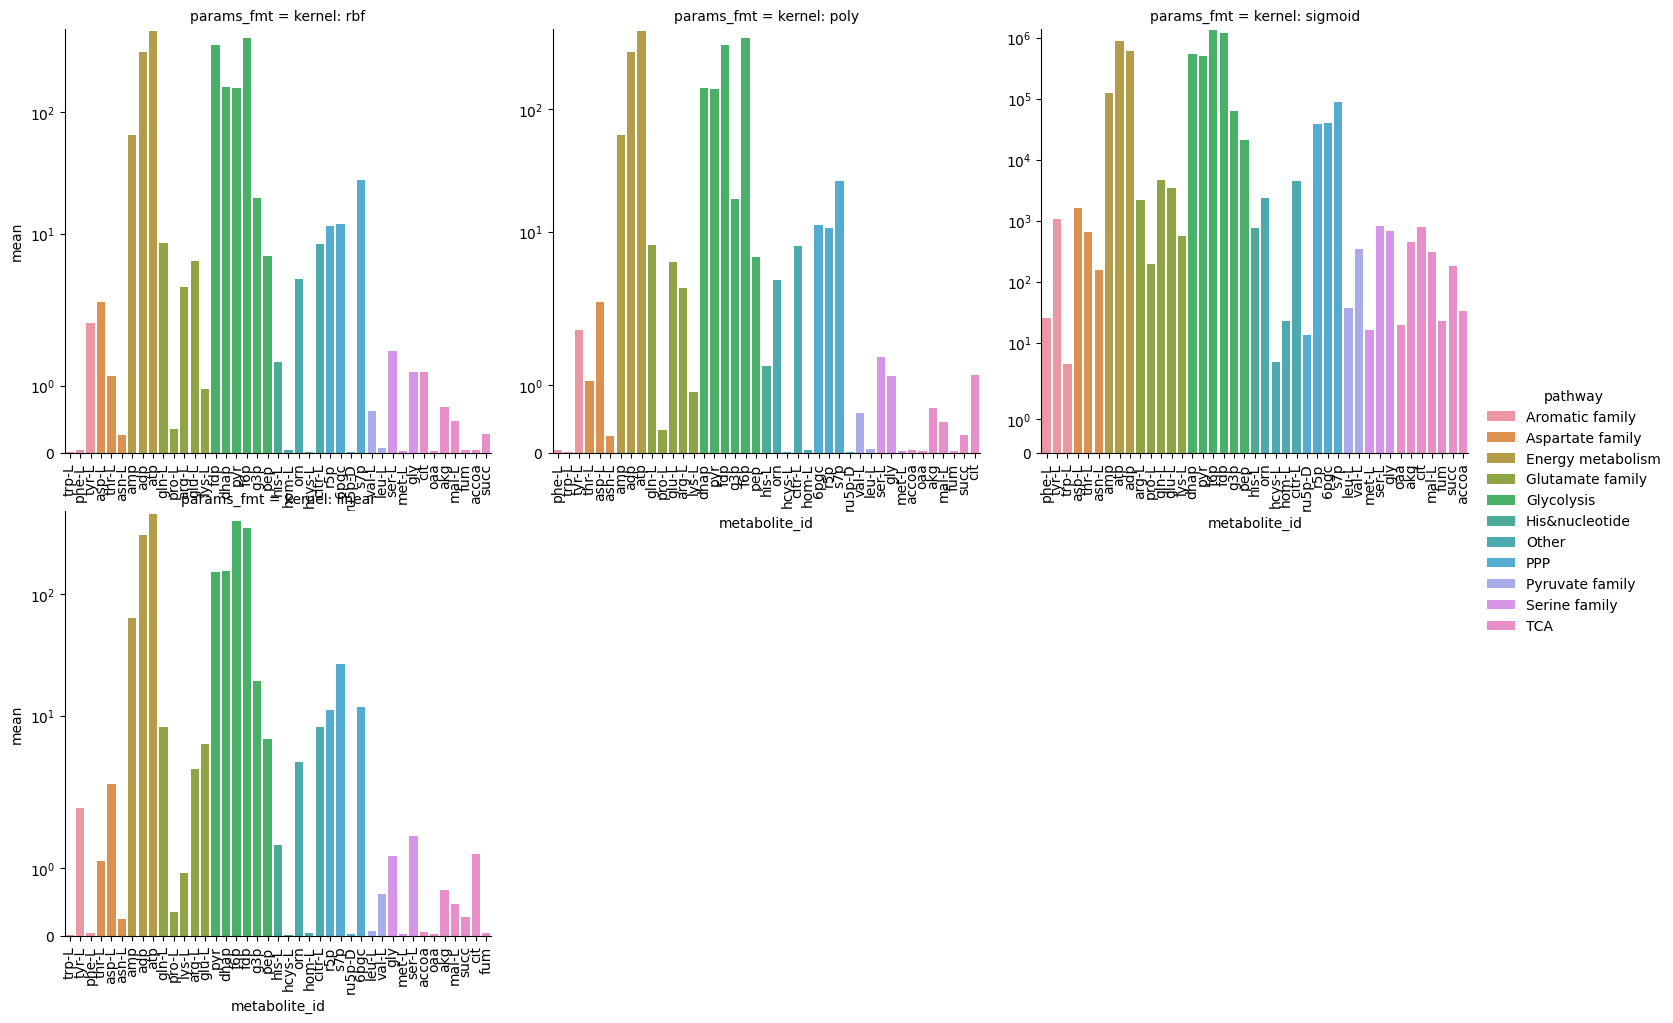

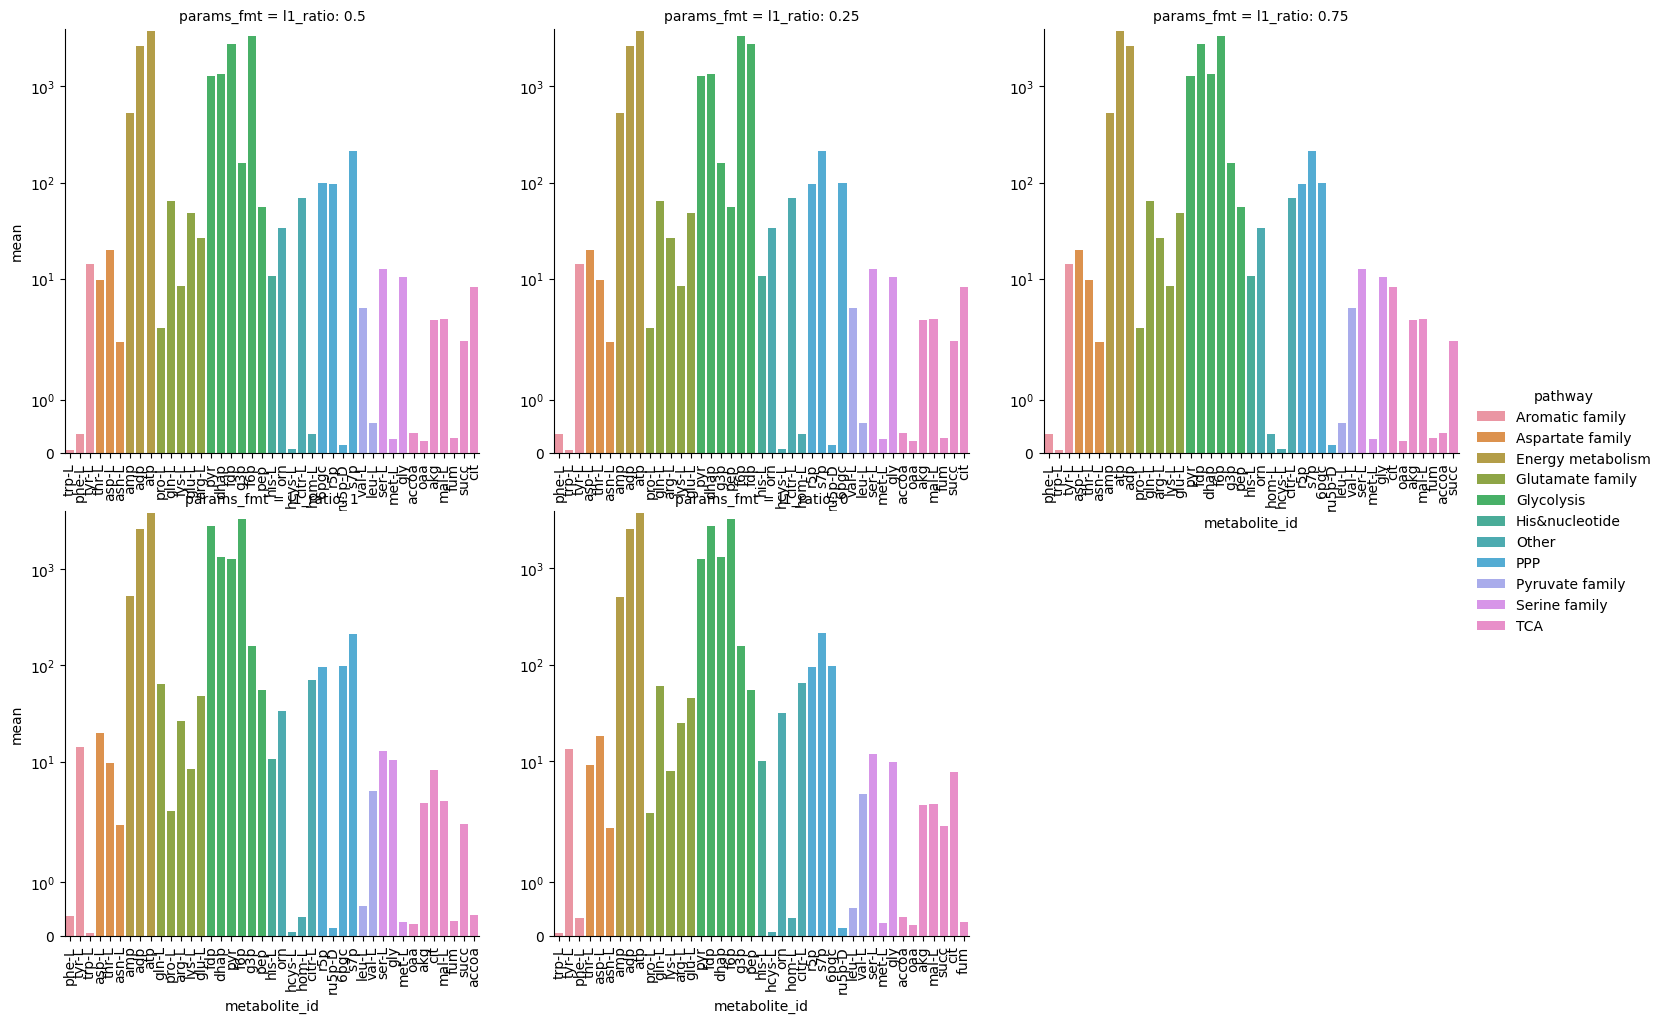

In [36]:

# grp_order = _df.index

for reggressor in df['regressor'].unique():
    _df = df[df['regressor'] == reggressor].sort_values('pathway')
    g = sns.catplot(
        x='metabolite_id',
        y='mean',
        hue='pathway',
        # row='regressor',
        col='params_fmt',
        col_wrap=3,
        sharey=False,
        sharex=False,
        kind='bar',
        data=_df,
        dodge=False,
    )

    g.set(yscale='symlog')
    g.set_xticklabels(rotation=90)

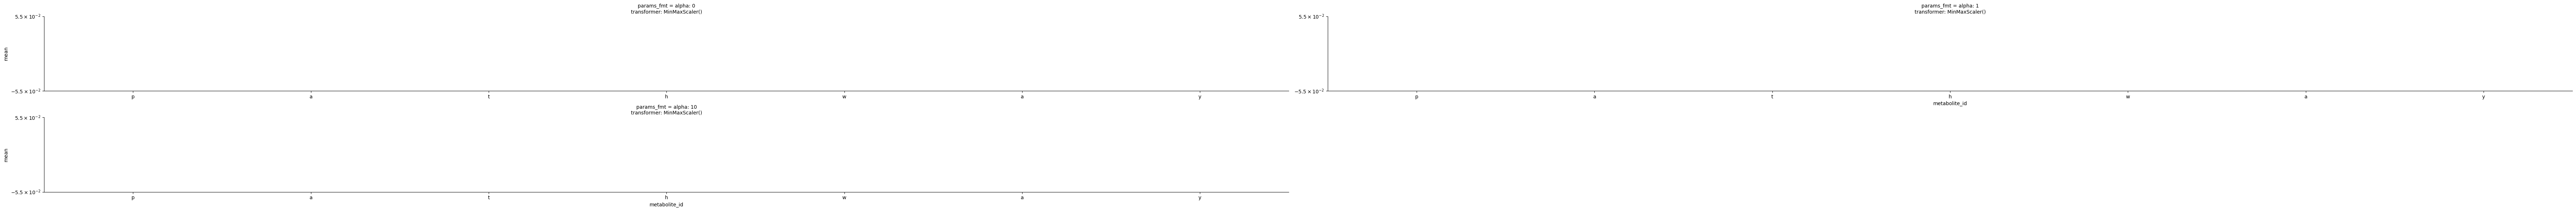

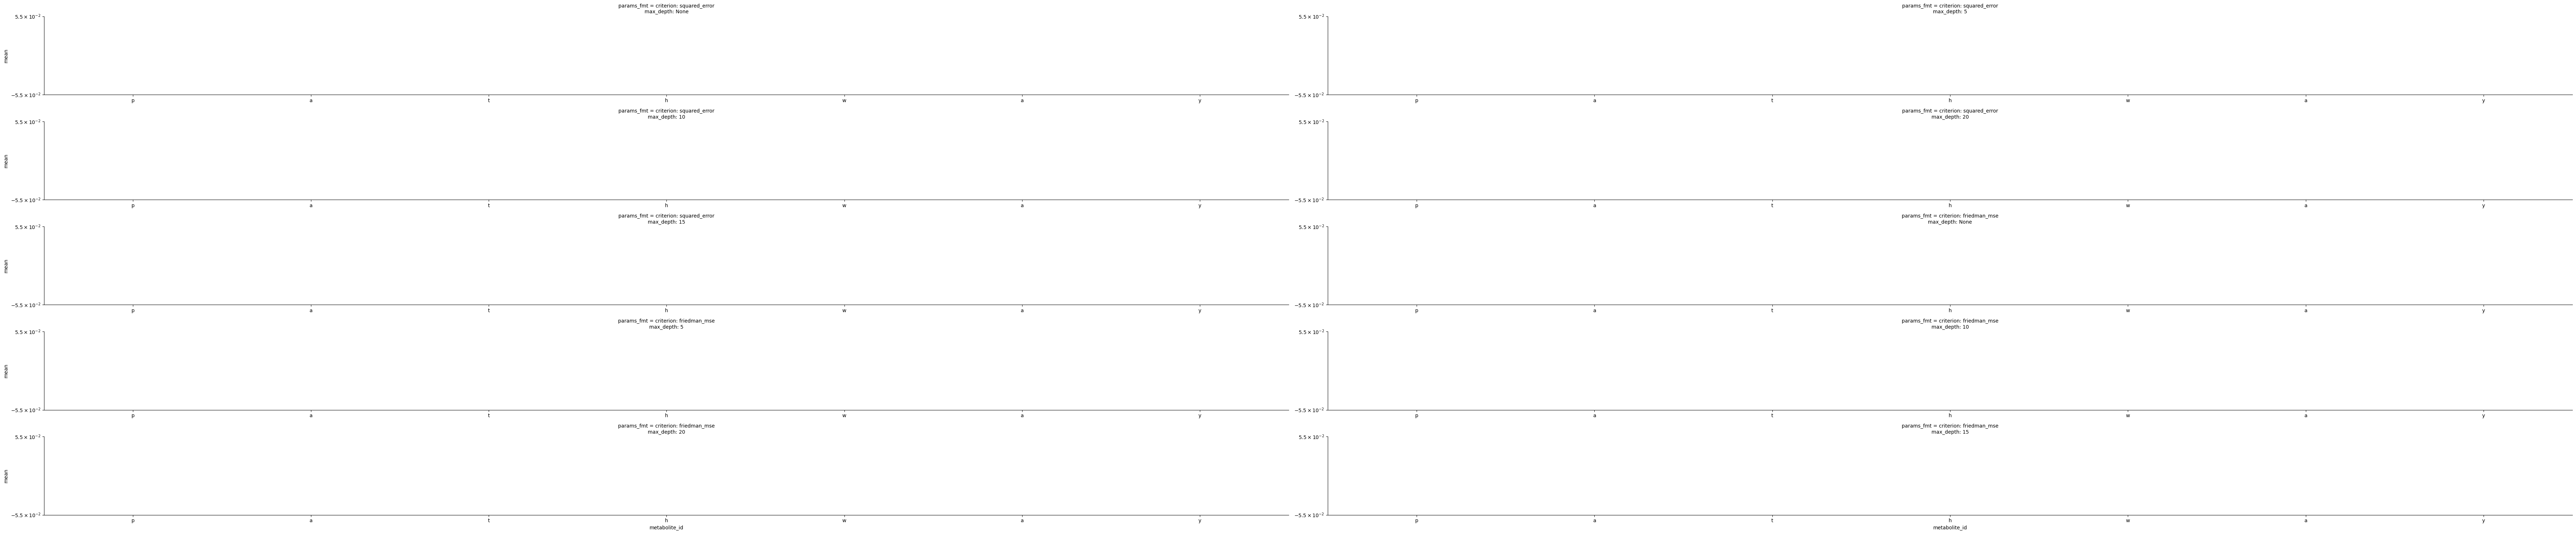

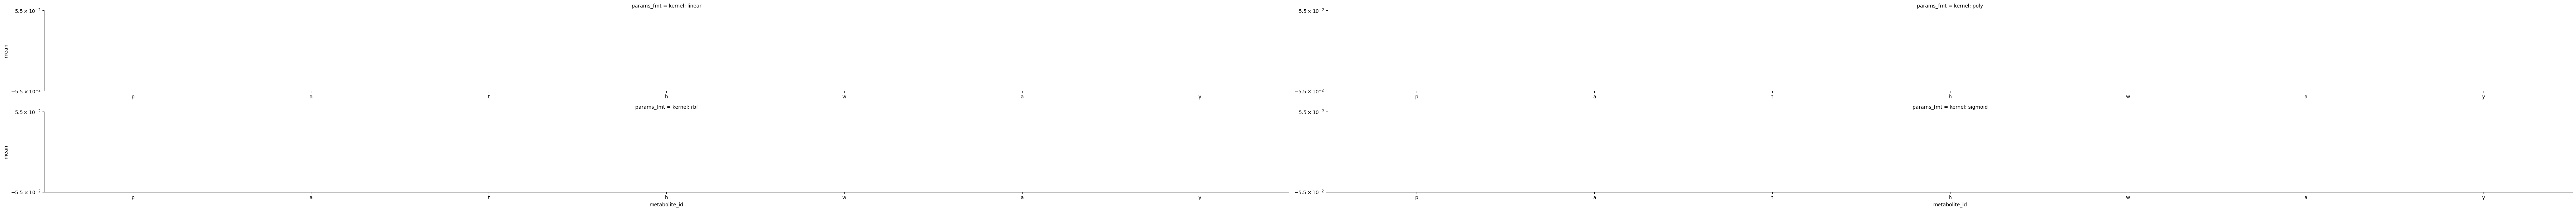

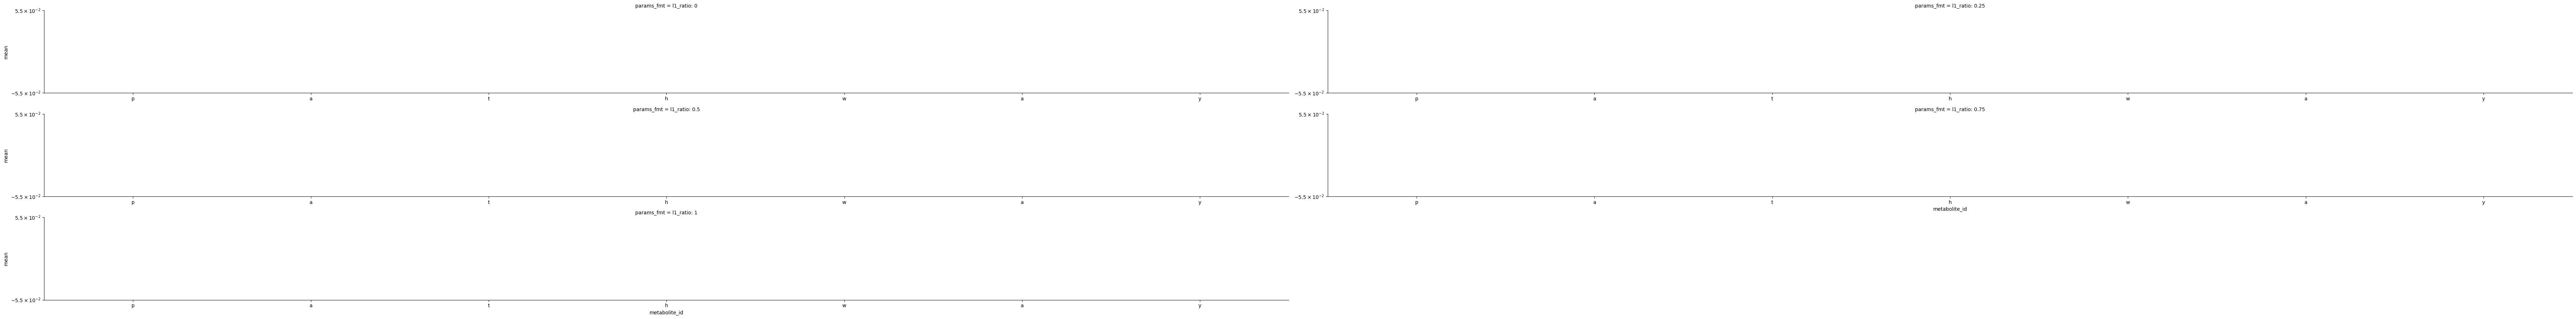

In [30]:
for reggressor in df['regressor'].unique():
    g = sns.FacetGrid(
        data=df[df['regressor'] == reggressor],
        col='params_fmt',
        col_wrap=2,
        height=3,
        aspect=12,
        sharey=False,
        sharex=False,
        palette='pastel',
    )
    g.set(yscale='symlog')
    g.map(sns.barplot, 'metabolite_id', 'mean', order='pathway')

/home/tvangraft/tudelft/thesis/.env/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/tvangraft/tudelft/thesis/.env/lib/python3.9/site-packages/seaborn/axisgrid.py:675: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


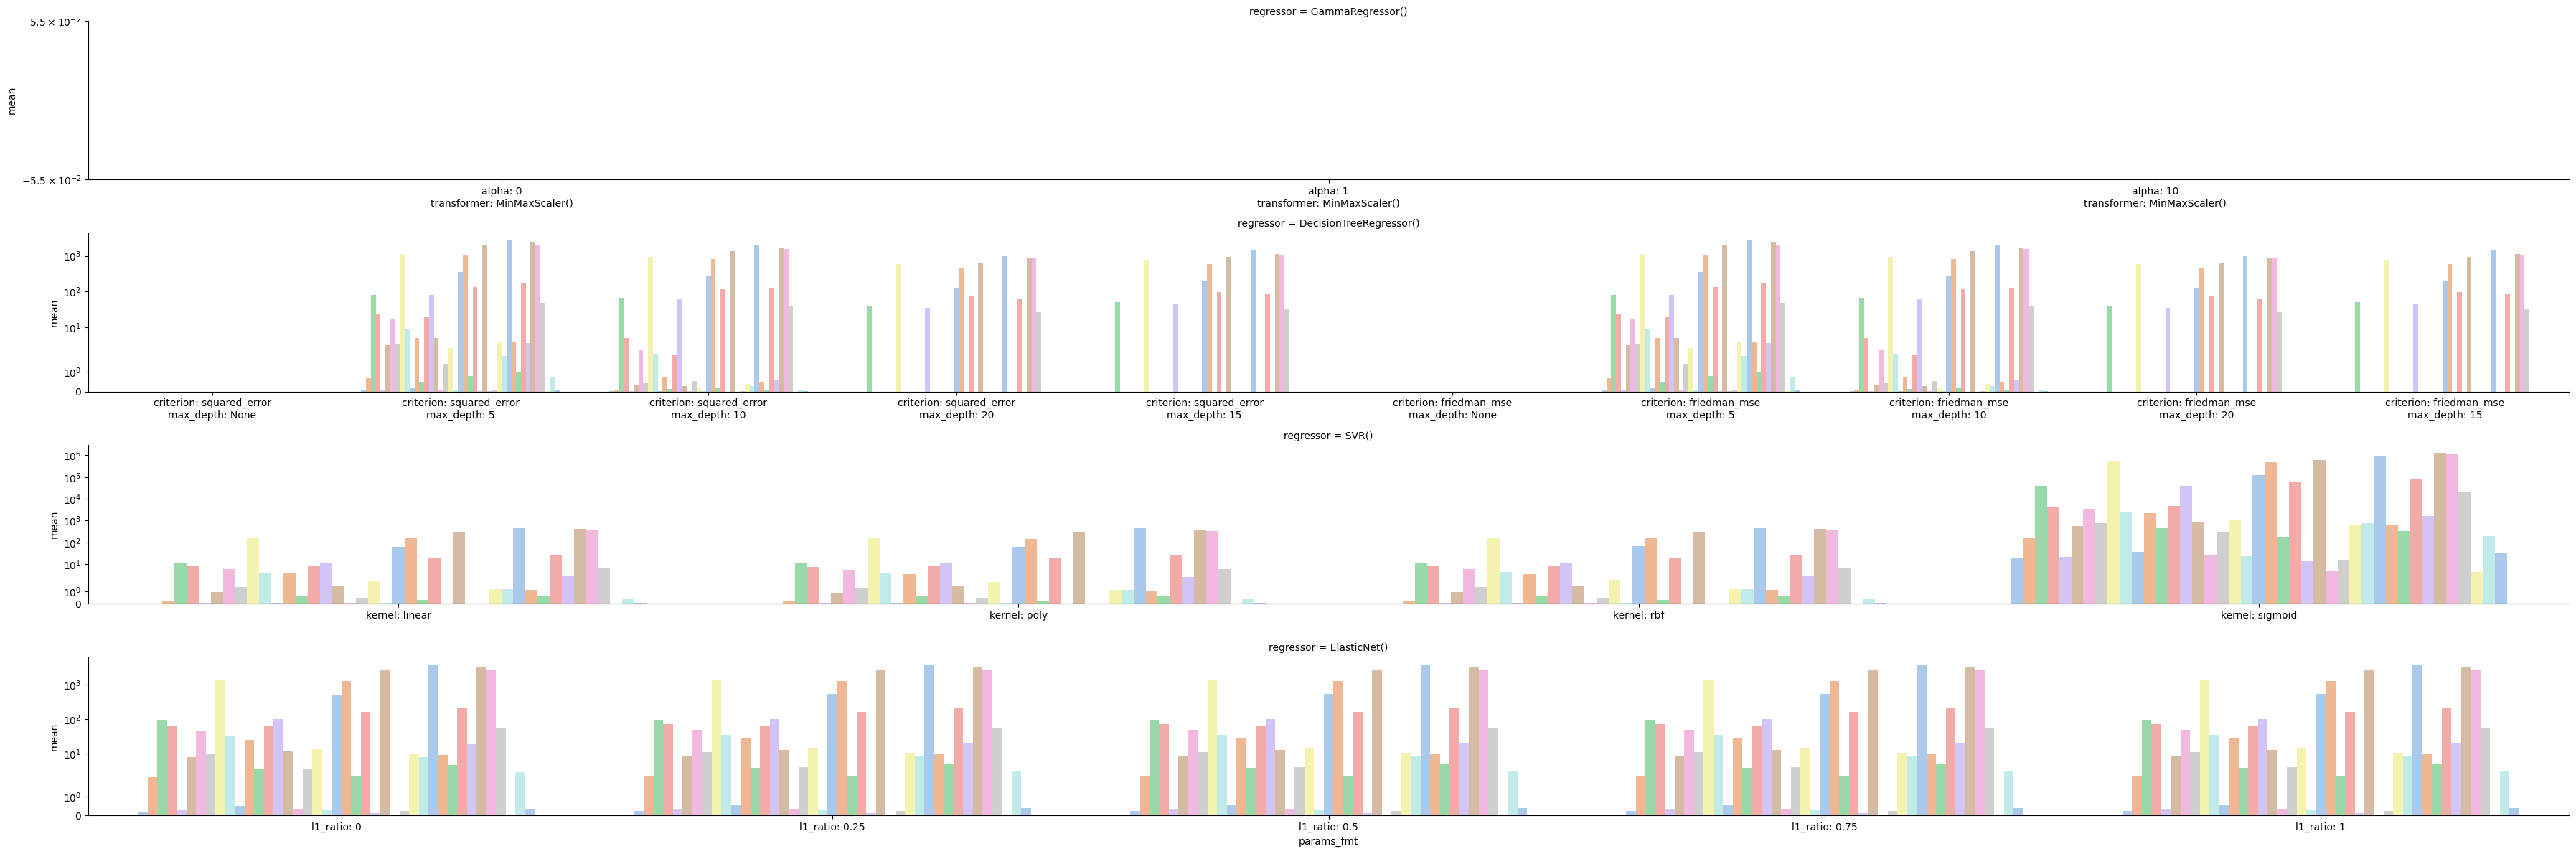

In [31]:
g = sns.FacetGrid(
    data=df,
    row='regressor',
    # col_wrap=2
    height=3,
    aspect=12,
    sharey=False,
    sharex=False
)
g.set(yscale='symlog')
g.map(sns.barplot, 'params_fmt', 'mean', 'metabolite_id', palette='pastel')

In [32]:
df.columns

Index(['Unnamed: 0', 'mean_fit_time', 'std_fit_time', 'mean_score_time',
       'std_score_time', 'regressor', 'regressor__alpha', 'param_transformer',
       'regressor__criterion', 'regressor__max_depth', 'regressor__kernel',
       'regressor__l1_ratio', 'params', 'split0', 'split1', 'split2', 'split3',
       'split4', 'split5', 'split6', 'split7', 'split8', 'split9', 'split10',
       'split11', 'split12', 'split13', 'split14', 'split15', 'split16',
       'split17', 'split18', 'split19', 'split20', 'split21', 'split22',
       'split23', 'split24', 'split25', 'split26', 'split27', 'split28',
       'split29', 'split30', 'split31', 'split32', 'split33', 'split34',
       'split35', 'split36', 'split37', 'split38', 'split39', 'split40',
       'split41', 'split42', 'split43', 'split44', 'split45', 'split46',
       'split47', 'split48', 'split49', 'mean', 'std', 'rank', 'metabolite_id',
       'params_fmt', 'official_name', 'kegg_id', 'pathway', 'method', 'Order'],
      dtype='obj

In [33]:
best_models

NameError: name 'best_models' is not defined

In [ ]:
best_models = df[df['rank'] == 1]
best_models['params_fmt']

11      criterion: friedman_mse\nmax_depth: 20
12      criterion: friedman_mse\nmax_depth: 15
8     criterion: friedman_mse\nmax_depth: None
11      criterion: friedman_mse\nmax_depth: 20
8     criterion: friedman_mse\nmax_depth: None
8     criterion: friedman_mse\nmax_depth: None
8     criterion: friedman_mse\nmax_depth: None
11      criterion: friedman_mse\nmax_depth: 20
8     criterion: friedman_mse\nmax_depth: None
11      criterion: friedman_mse\nmax_depth: 20
11      criterion: friedman_mse\nmax_depth: 20
12      criterion: friedman_mse\nmax_depth: 15
8     criterion: friedman_mse\nmax_depth: None
11      criterion: friedman_mse\nmax_depth: 20
8     criterion: friedman_mse\nmax_depth: None
8     criterion: friedman_mse\nmax_depth: None
8     criterion: friedman_mse\nmax_depth: None
11      criterion: friedman_mse\nmax_depth: 20
8     criterion: friedman_mse\nmax_depth: None
8     criterion: friedman_mse\nmax_depth: None
12      criterion: friedman_mse\nmax_depth: 15
12      crite